In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn import preprocessing
import pandas as pd
from sklearn.preprocessing import StandardScaler
from prettytable import PrettyTable

import datetime
import seaborn as sns
import time
import numpy as np
import pandas as pd
from ta.trend import ema_indicator
import ta
import matplotlib.ticker as ticker
import statistics

In [2]:
profit_window = 720
rsi_window = 21
time_delta = 60
profit=0.005
rsi_threshold = 25
max_profit_window = 60*36

In [3]:
def calc_rsi(data):
    data = list(data)
    up = 0
    down = 0
    for i in range(1, len(data)):
        if data[i] < data[i-1]:
            down += data[i-1] - data[i]
        else:
            up += data[i] - data[i-1]
    rs = up / down if down != 0 else 0
    rsi = round(100 - 100/(1+rs)) if rs != 0 else 100
    return rsi

def sliding_window(data, windows, funcs, func_columns):
    df = data
    serieses = [pd.Series(np.zeros(df.shape[0])) for k in range(len(funcs))]
    for i in df.index[max(windows)-1:]:
        for k in range(len(funcs)):  
            serieses[k][i]= funcs[k](df[func_columns[k]].iloc[i-windows[k]+1:i+1])
    return serieses  

def calc_specs(data, predict_column, answer_column):
    TP = 0
    TN = 0
    FP = 0
    FN = 0
    for k in range(data.shape[0]):
        if data[predict_column].iloc[k] == data[answer_column].iloc[k] == 1:
            TP += 1
        elif data[predict_column].iloc[k] > data[answer_column].iloc[k]:
            FP += 1
        elif data[predict_column].iloc[k] < data[answer_column].iloc[k]:  
            FN += 1
        else:
            TN += 1
    
    th = ['/','predicted 0','predicted 1']

    table = PrettyTable(th) 

    table.add_row(['actual 0',TN,FP])
    table.add_row(['actual 1',FN,TP])
    
    recall = TP/(TP + FN) if (TP + FN) != 0 else None
    precision = TP/(TP + FP) if (TP + FP) != 0 else None
    print(table)
    print('recall: ',recall)
    print('precision', precision)

In [4]:
def add_columns(df):
    df_of_candles = df
    df_of_candles['time']=df_of_candles['time'].astype('datetime64[ns, UTC]')
    df_of_candles['rsi6_ta'] = ta.momentum.rsi(close = df_of_candles['close'], window=6)
    df_of_candles['rsi12_ta'] = ta.momentum.rsi(close = df_of_candles['close'], window=12)
    df_of_candles['rsi24_ta'] = ta.momentum.rsi(close = df_of_candles['close'], window=24)
    df_of_candles['rsi30_ta'] = ta.momentum.rsi(close = df_of_candles['close'], window=30)
    
    df_of_candles['ema5'] = ema_indicator(close = df_of_candles['close'], window=5)
    df_of_candles['ema10'] = ema_indicator(close = df_of_candles['close'], window=10)
    df_of_candles['ema30'] = ema_indicator(close = df_of_candles['close'], window=30)
    
    df_of_candles['-DI']= ta.trend.adx_neg(high= df_of_candles['high'], low= df_of_candles['low'], close= df_of_candles['close'], window=30, fillna=False)
    df_of_candles['+DI']= ta.trend.adx_pos(high= df_of_candles['high'], low= df_of_candles['low'], close= df_of_candles['close'], window=30, fillna=False)
    df_of_candles['adx_ta']= ta.trend.adx(high= df_of_candles['high'], low= df_of_candles['low'], close= df_of_candles['close'], window=30, fillna=False)
    
    df_of_candles['rsi12'], df_of_candles['rsi6'], df_of_candles['rsi24'], df_of_candles['rsi30'], df_of_candles['rsi40'],df_of_candles['rsi50'] = sliding_window(df_of_candles, [12,6,24,30, 40, 50], [calc_rsi for k in range(6)], ['close' for k in range(6)])
    df_of_candles = pd.concat([df_of_candles.iloc[50:]], ignore_index=True)
    return(df_of_candles)

In [5]:
def make_data(df):
    df_of_candles = df
    df_cross=pd.DataFrame()
    for i in df_of_candles.index[1:-profit_window-1]:
        skip_trigger = False
        for k in range(1, profit_window): 
            if (df_of_candles['time'][i+k] - df_of_candles['time'][i+k-1]).total_seconds()  > time_delta:
                skip_trigger = True
                print(df_of_candles['time'][i+k], ' ', df_of_candles['time'][i+k-1])
                break
        if skip_trigger:
            continue
        profit_trigger = False
        max_profit = 0
        max_loss = 0
        time_needed = 0
        for k in range(120, profit_window + 1):
            candles = df_of_candles['close'].iloc[k-119: k]
            if max_profit < (df_of_candles['close'][i + k]/df_of_candles['close'][i] - 1)*100:
                max_profit = (df_of_candles['close'][i + k]/df_of_candles['close'][i] - 1)*100
            if df_of_candles['close'][i + k]>=df_of_candles['close'][i]*(profit+1):
                profit_trigger = True
            if max_loss < (1 - df_of_candles['close'][i + k]/df_of_candles['close'][i])*100:
                max_loss = (1 - df_of_candles['close'][i + k]/df_of_candles['close'][i])*100
#         if i < df_of_candles.shape[0] - max_profit_window:
#             for k in range(1, max_profit_window + 1):
#                 if df_of_candles['close'][i + k]>=df_of_candles['close'][i]*(profit+1):
#                     time_needed = (df_of_candles['time'][i + k] - df_of_candles['time'][i]).total_seconds()/60/60
                
        new_line = {
                    'max_fall': 1- df_of_candles['close'][i]/max(candles),
                    'max_fall_median': 1- df_of_candles['close'][i]/statistics.median(candles),
                    'max_fall_mean': 1- df_of_candles['close'][i]/statistics.mean(candles),
                    'price': df_of_candles['close'][i],
                    'time': df_of_candles['time'][i],
                    'volume': df_of_candles['volume'][i],
                    
                    'time_needed': time_needed,
                    'max_profit': max_profit,
                    'max_loss': max_loss,
            
                    'ema5': df_of_candles['ema5'][i],
                    'ema10': df_of_candles['ema10'][i],
                    'ema30': df_of_candles['ema30'][i],
            
                    'adx': df_of_candles['adx_ta'][i],
                    '+DI': df_of_candles['-DI'][i],
                    '-DI': df_of_candles['+DI'][i],
            
                    'rsi6': df_of_candles['rsi6'][i],
                    'rsi12': df_of_candles['rsi12'][i],
                    'rsi24': df_of_candles['rsi24'][i],
                    'rsi30': df_of_candles['rsi30'][i],
                    'rsi6_ta': df_of_candles['rsi6_ta'][i],
                    'rsi12_ta': df_of_candles['rsi12_ta'][i],
                    'rsi24_ta': df_of_candles['rsi24_ta'][i],
                    'rsi30_ta': df_of_candles['rsi30_ta'][i],
                    f'rsi6<{rsi_threshold}': int(df_of_candles['rsi6'][i]<rsi_threshold),
                    f'rsi12<{rsi_threshold}': int(df_of_candles['rsi12'][i]<rsi_threshold),
                    f'rsi24<{rsi_threshold}': int(df_of_candles['rsi24'][i]<rsi_threshold),
            
                    f'rsi30<{rsi_threshold}': int(df_of_candles['rsi30'][i]<rsi_threshold),
                    f'up_rsi30<{rsi_threshold}': int( (df_of_candles['rsi30'][i]>=rsi_threshold) and (df_of_candles['rsi30'][i-1]<=rsi_threshold)),
            
                    f'rsi40<{rsi_threshold}': int(df_of_candles['rsi40'][i]<rsi_threshold),
                    f'rsi50<{rsi_threshold}': int(df_of_candles['rsi50'][i]<rsi_threshold),
                    f'rsi6_ta<{rsi_threshold}': int(df_of_candles['rsi6_ta'][i]<rsi_threshold),
                    f'rsi12_ta<{rsi_threshold}': int(df_of_candles['rsi12_ta'][i]<rsi_threshold),
                    f'rsi24_ta<{rsi_threshold}': int(df_of_candles['rsi24_ta'][i]<rsi_threshold),
                    f'rsi30_ta<{rsi_threshold}': int(df_of_candles['rsi30_ta'][i]<rsi_threshold),
                    'Up?': profit_trigger,}
        df_cross = df_cross.append(new_line,ignore_index=True)
    return df_cross

In [6]:
df_of_candles = pd.read_csv('Data/DataPoloniex1.csv') 
df_of_candles = add_columns(df_of_candles)

C:\Users\nikit\anaconda3\lib\site-packages\ta\trend.py:769: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
C:\Users\nikit\anaconda3\lib\site-packages\ta\trend.py:774: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


In [7]:
df_cross = make_data(df_of_candles)
y = df_cross['Up?']

In [8]:
df_cross

,max_fall,max_fall_median,max_fall_mean,price,time,volume,time_needed,max_profit,max_loss,ema5,...,rsi24<25,rsi30<25,up_rsi30<25,rsi40<25,rsi50<25,rsi6_ta<25,rsi12_ta<25,rsi24_ta<25,rsi30_ta<25,Up?
0,0.003275,-0.005551,-0.004317,0.07608,2022-08-23 05:32:59+00:00,0.001,0.0,0.328601,1.932177,0.076086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003144,-0.005683,-0.004449,0.07609,2022-08-23 05:33:59+00:00,0.004,0.0,0.315416,1.945065,0.076087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003144,-0.005683,-0.004449,0.07609,2022-08-23 05:34:59+00:00,0.000,0.0,0.315416,1.945065,0.076088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003537,-0.005287,-0.004053,0.07606,2022-08-23 05:35:59+00:00,0.004,0.0,0.354983,1.906390,0.076079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001834,-0.007005,-0.005770,0.07619,2022-08-23 05:36:59+00:00,0.010,0.0,0.183751,2.073763,0.076116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44523,0.099699,0.091726,0.092841,0.06872,2022-09-23 03:35:59+00:00,0.013,0.0,1.382421,1.076834,0.068776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44524,0.099568,0.091594,0.092708,0.06873,2022-09-23 03:36:59+00:00,1.279,0.0,1.367671,1.091227,0.068761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44525,0.099568,0.091594,0.092708,0.06873,2022-09-23 03:37:59+00:00,0.004,0.0,1.367671,1.091227,0.068750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44526,0.099830,0.091858,0.092973,0.06871,2022-09-23 03:38:59+00:00,0.013,0.0,1.397177,1.062436,0.068737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [9]:
for column in [f'rsi6<{rsi_threshold}', f'rsi12<{rsi_threshold}', f'rsi24<{rsi_threshold}', f'rsi30<{rsi_threshold}', f'rsi40<{rsi_threshold}', f'rsi50<{rsi_threshold}', f'up_rsi30<{rsi_threshold}']:
    print(column)
    calc_specs(df_cross, column, 'Up?')
    print('\n')

rsi6<25
+----------+-------------+-------------+
|    /     | predicted 0 | predicted 1 |
+----------+-------------+-------------+
| actual 0 |    13537    |     2322    |
| actual 1 |    24762    |     3907    |
+----------+-------------+-------------+
recall:  0.13627960514841816
precision 0.6272274843474073


rsi12<25
+----------+-------------+-------------+
|    /     | predicted 0 | predicted 1 |
+----------+-------------+-------------+
| actual 0 |    13886    |     1973    |
| actual 1 |    25287    |     3382    |
+----------+-------------+-------------+
recall:  0.11796714220935506
precision 0.6315592903828198


rsi24<25
+----------+-------------+-------------+
|    /     | predicted 0 | predicted 1 |
+----------+-------------+-------------+
| actual 0 |    14992    |     867     |
| actual 1 |    27489    |     1180    |
+----------+-------------+-------------+
recall:  0.041159440510656106
precision 0.5764533463605276


rsi30<25
+----------+-------------+-------------+
|    

In [10]:
df_cross

,max_fall,max_fall_median,max_fall_mean,price,time,volume,time_needed,max_profit,max_loss,ema5,...,rsi24<25,rsi30<25,up_rsi30<25,rsi40<25,rsi50<25,rsi6_ta<25,rsi12_ta<25,rsi24_ta<25,rsi30_ta<25,Up?
0,0.003275,-0.005551,-0.004317,0.07608,2022-08-23 05:32:59+00:00,0.001,0.0,0.328601,1.932177,0.076086,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.003144,-0.005683,-0.004449,0.07609,2022-08-23 05:33:59+00:00,0.004,0.0,0.315416,1.945065,0.076087,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.003144,-0.005683,-0.004449,0.07609,2022-08-23 05:34:59+00:00,0.000,0.0,0.315416,1.945065,0.076088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.003537,-0.005287,-0.004053,0.07606,2022-08-23 05:35:59+00:00,0.004,0.0,0.354983,1.906390,0.076079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.001834,-0.007005,-0.005770,0.07619,2022-08-23 05:36:59+00:00,0.010,0.0,0.183751,2.073763,0.076116,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44523,0.099699,0.091726,0.092841,0.06872,2022-09-23 03:35:59+00:00,0.013,0.0,1.382421,1.076834,0.068776,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44524,0.099568,0.091594,0.092708,0.06873,2022-09-23 03:36:59+00:00,1.279,0.0,1.367671,1.091227,0.068761,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44525,0.099568,0.091594,0.092708,0.06873,2022-09-23 03:37:59+00:00,0.004,0.0,1.367671,1.091227,0.068750,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
44526,0.099830,0.091858,0.092973,0.06871,2022-09-23 03:38:59+00:00,0.013,0.0,1.397177,1.062436,0.068737,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [11]:
#[7600:7700] - большое падение

In [12]:
X_plot = df_cross

times = X_plot['time']
prices=X_plot['price']
pred=X_plot['up_rsi30<25']
actual=X_plot['Up?']
mistakes = []
successes = []
for k in range(pred.shape[0]):
    if pred[k] > actual[k]:
        mistakes.append(k)
    elif pred[k] == actual[k] == 1:
        successes.append(k) 
print('mistakes: ', mistakes)
print('successes: ', successes)
yerr = [i*profit for i in prices]

xy=list(zip(times,prices,pred,actual,yerr, X_plot['rsi6'], X_plot['rsi12'],X_plot['rsi24'],X_plot['rsi30'], X_plot['ema5'], X_plot['ema10'], X_plot['ema30'], X_plot['volume'], X_plot['adx'], X_plot['+DI'], X_plot['-DI']))
#xy=xy[4500:5200]

times_x=[i[0] for i in xy]
prices_y=[i[1] for i in xy]

true = [(i[0],i[1]) if i[2]==i[3] else 0 for i in xy]
false = [(i[0],i[1]) if i[2]!=i[3] else 0 for i in xy]

true = list(filter(lambda x: x!=0,true))
false = list(filter(lambda x: x!=0,false))
x_true= [i[0] for i in true]
y_true= [i[1] for i in true]
x_false= [i[0] for i in false]
y_false= [i[1] for i in false]

true11 = [(i[0],i[1]) if i[2]==i[3]==1 else 0 for i in xy]
true00 = [(i[0],i[1]) if i[2]==i[3]==0 else 0 for i in xy]
false10 = [(i[0],i[1]) if (i[2]*i[3]+i[2]==1) else 0 for i in xy]
false01 = [(i[0],i[1]) if i[2]*i[3]+i[3]==1 else 0 for i in xy]

true11 = list(filter(lambda x: x!=0,true11))
true00 = list(filter(lambda x: x!=0,true00))
false10 = list(filter(lambda x: x!=0,false10))
false01 = list(filter(lambda x: x!=0,false01))

x_true11 = [i[0] for i in true11]
y_true11 =[i[1] for i in true11]

x_true00 = [i[0] for i in true00]
y_true00 =[i[1] for i in true00]

x_false10 = [i[0] for i in false10]
y_false10 =[i[1] for i in false10]

x_false01 = [i[0] for i in false01]
y_false01 =[i[1] for i in false01]

yerr = [i[4] for i in xy]

rsi6 = [i[5] for i in xy]
rsi12 = [i[6] for i in xy]
rsi24 = [i[7] for i in xy]
rsi30 = [i[8] for i in xy]
ema5 = [i[9] for i in xy]
ema10 = [i[10] for i in xy]
ema30 = [i[11] for i in xy]
volumes = [i[12] for i in xy]
adx = [i[13] for i in xy]
plus_di = [i[14] for i in xy]
minus_di = [i[15] for i in xy]
fig, axs = plt.subplots(ncols=1, nrows=7)
fig.set_size_inches(100,200)
plt.rcParams['font.size'] = '16'

axs[0].plot(times_x,prices_y,color='blue')

axs[2] = axs[1].twinx()
axs[1].scatter(x_true11,y_true11,color='green',s=500.0)
axs[1].scatter(x_false10,y_false10,color='red',s=500.0)
axs[1].scatter(x_false01,y_false01,color='orange',s=500.0)
axs[1].plot(times_x,prices_y,color='black',linewidth = 6)

#axs[1].plot(times_x,ema5,color='forestgreen',linewidth = 4, label='ema5')
#axs[1].plot(times_x,ema10,color='deeppink',linewidth = 4, label='ema10')
#axs[1].plot(times_x,ema30,color='blue',linewidth = 4, label='ema30')

axs[1].errorbar(x_false10,y_false10,yerr=list(map(lambda x:x*profit,y_false10)), linestyle="None",color='red')
axs[1].legend(loc='upper left',fontsize = 80)

#axs[2].plot(times_x,rsi6,color='purple',linewidth = 6, label = 'rsi6')
#axs[2].plot(times_x,rsi12,color='green',linewidth = 6, label = 'rsi12')
axs[2].plot(times_x,rsi30,color='orange',linewidth = 9, label = 'rsi30')

axs[2].yaxis.set_major_locator(ticker.MultipleLocator(10))
axs[2].set_ylim([0, 300])
axs[1].set_ylim([min(prices_y)-(max(prices_y)*(1+profit)-min(prices_y))*0.52, max(prices_y)*(1+profit)])
axs[2].hlines(100, times_x[0], times_x[-1], color = 'r', linewidth = 5, linestyle = ':')
axs[2].hlines(0, times_x[0], times_x[-1], color = 'r', linewidth = 5, linestyle = ':')
axs[2].hlines(rsi_threshold, times_x[0], times_x[-1], color = 'g', linewidth = 5, linestyle = ':')
axs[2].legend(fontsize = 80)
#axs[7].plot(times_x,emas,color='orange')
#axs[6].plot(times_x,normalized_volume,color='blue')
# axs[8].plot(times_x,rsi,color='purple')
# axs[8].plot(times_x,my_rsi,color='green')
#axs[2].plot(times_x,adx,color='green',linewidth = 3)
#axs[2].plot(times_x,plus_di,color='blue',linewidth = 3)
#axs[2].plot(times_x,minus_di,color='red',linewidth = 3)
#plt.xlabel('Importance', fontsize=25, weight = 'bold')
#plt.ylabel('Features', fontsize=25, weight = 'bold')
#plt.title('Feature Importance', fontsize=25, weight = 'bold')

axs[4] = axs[3].twinx()
axs[3].plot([k for k in range(len(times_x))],prices_y,color='black',linewidth = 6)

axs[4].bar([k for k in range(len(times_x))],volumes, color = 'green')


axs[6] = axs[5].twinx()
axs[5].plot(times_x,prices_y,color='black',linewidth = 6)
axs[5].scatter(x_true11,y_true11,color='green',s=500.0)
axs[5].scatter(x_false10,y_false10,color='red',s=500.0)
axs[6].plot(times_x, adx, color='blue')
axs[6].plot(times_x, plus_di, color='green')
axs[6].plot(times_x, minus_di, color='red')

for ax in axs:
    ax.tick_params(labelsize = 45)
    



display(plt.show())
fig.savefig('Graph_images/saved_figure2.png')
#print(times_x[0],prices_y[0])
#print(list(zip(times_x, prices_y)))

mistakes:  [1321, 3815, 3816, 4033, 4099, 4102, 4111, 4437, 4438, 4440, 4493, 4991, 5116, 5151, 5155, 5171, 5173, 5214, 5529, 5530, 5714, 6281, 6284, 6289, 6295, 6296, 6298, 7579, 7580, 7581, 8377, 11679, 11730, 11731, 12577, 12584, 15278, 15279, 15280, 15281, 15343, 15346, 15371, 15373, 15378, 15381, 15382, 15384, 15710, 15830, 15832, 15840, 16128, 17075, 21411, 21412, 21417, 21418, 21419, 21426, 21436, 21437, 21445, 21448, 21496, 21497, 22809, 24131, 24396, 24441, 24442, 24443, 24445, 24523, 24540, 24581, 24651, 24709, 24714, 24715, 24765, 24770, 24869, 24878, 25254, 25977, 25978, 27302, 27309, 27310, 27317, 27319, 28011, 28012, 28159, 28166, 28167, 28215, 28361, 28362, 28404, 28405, 28406, 28461, 28462, 28463, 28469, 28503, 28599, 28713, 28723, 28913, 29363, 29364, 29365, 29369, 29375, 29379, 29396, 29511, 29517, 29518, 29519, 29532, 29715, 29817, 31357, 33512, 33552, 33554, 34053, 34217, 34272, 34523, 34525, 35154, 35163, 35394, 35786, 35791, 35798, 35800, 35801, 35802, 35804, 3580

No handles with labels found to put in legend.


None

In [13]:
# %matplotlib notebook
# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.widgets import Slider

# fig, ax = plt.subplots()
# plt.subplots_adjust(bottom=0.25)

# t = np.arange(0.0, 100.0, 0.1)
# s = np.sin(2*np.pi*t)
# l, = plt.plot(t,s)
# plt.axis([0, 10, -1, 1])

# axcolor = 'lightgoldenrodyellow'
# axpos = plt.axes([0.2, 0.1, 0.65, 0.03], facecolor=axcolor)

# spos = Slider(axpos, 'Pos', 0.1, 90.0)

# def update(val):
#     pos = spos.val
#     ax.axis([pos,pos+10,-1,1])
#     fig.canvas.draw_idle()

# spos.on_changed(update)

# plt.show()

In [14]:
# def datetime_to_timestamp(dt):
#     return time.mktime(dt.timetuple()) + dt.microsecond/1e6

# %matplotlib notebook
# from matplotlib.widgets import Slider

# X_plot = df_cross

# times = [datetime_to_timestamp(i) for i in X_plot['time']]
# prices=X_plot['price']
# pred=X_plot['rsi6<25']
# actual=X_plot['Up?']


# yerr = [i*profit for i in prices]

# xy=list(zip(times,prices,pred,actual,yerr, X_plot['rsi6'], X_plot['rsi12'],X_plot['rsi24'],X_plot['rsi30']))
# xy=xy[300:400]

# times_x=[i[0] for i in xy]
# prices_y=[i[1] for i in xy]

# true = [(i[0],i[1]) if i[2]==i[3] else 0 for i in xy]
# false = [(i[0],i[1]) if i[2]!=i[3] else 0 for i in xy]

# true = list(filter(lambda x: x!=0,true))
# false = list(filter(lambda x: x!=0,false))
# x_true= [i[0] for i in true]
# y_true= [i[1] for i in true]
# x_false= [i[0] for i in false]
# y_false= [i[1] for i in false]

# true11 = [(i[0],i[1]) if i[2]==i[3]==1 else 0 for i in xy]
# true00 = [(i[0],i[1]) if i[2]==i[3]==0 else 0 for i in xy]
# false10 = [(i[0],i[1]) if (i[2]*i[3]+i[2]==1) else 0 for i in xy]
# false01 = [(i[0],i[1]) if i[2]*i[3]+i[3]==1 else 0 for i in xy]

# true11 = list(filter(lambda x: x!=0,true11))
# true00 = list(filter(lambda x: x!=0,true00))
# false10 = list(filter(lambda x: x!=0,false10))
# false01 = list(filter(lambda x: x!=0,false01))

# x_true11 = [i[0] for i in true11]
# y_true11 =[i[1] for i in true11]

# x_true00 = [i[0] for i in true00]
# y_true00 =[i[1] for i in true00]

# x_false10 = [i[0] for i in false10]
# y_false10 =[i[1] for i in false10]

# x_false01 = [i[0] for i in false01]
# y_false01 =[i[1] for i in false01]

# yerr = [i[4] for i in xy]

# rsi6 = [i[5] for i in xy]
# rsi12 = [i[6] for i in xy]
# rsi24 = [i[7] for i in xy]
# rsi30 = [i[8] for i in xy]


# fig, axs = plt.subplots(ncols=1, nrows=3)
# #fig.set_size_inches(100,200)
# #plt.rcParams['font.size'] = '16'

# axs[0].plot(times_x,prices_y,color='blue')

# # axs[2] = axs[1].twinx()
# # axs[1].scatter(x_true11,y_true11,color='green',s=500.0)
# # axs[1].scatter(x_false10,y_false10,color='red',s=500.0)
# # axs[1].scatter(x_false01,y_false01,color='orange',s=500.0)
# axs[1].plot(times_x,prices_y,color='black',linewidth = 6)
# # axs[1].errorbar(x_false10,y_false10,yerr=list(map(lambda x:x*profit,y_false10)), linestyle="None",color='red')

# #axs[2].plot(times_x,rsi6,color='purple',linewidth = 6, label = 'rsi6')
# #axs[2].plot(times_x,rsi12,color='green',linewidth = 6, label = 'rsi12')
# #axs[2].plot(times_x,rsi30,color='orange',linewidth = 6, label = 'rsi30')
# # axs[2].yaxis.set_major_locator(ticker.MultipleLocator(10))
# # axs[2].set_ylim([0, 300])
# # axs[1].set_ylim([min(prices_y)-(max(prices_y)*(1+profit)-min(prices_y))*0.52, max(prices_y)*(1+profit)])
# # axs[2].hlines(100, times_x[0], times_x[-1], color = 'r', linewidth = 5, linestyle = ':')
# # axs[2].hlines(0, times_x[0], times_x[-1], color = 'r', linewidth = 5, linestyle = ':')
# # axs[2].hlines(25, times_x[0], times_x[-1], color = 'r', linewidth = 5, linestyle = ':')
# #axs[2].legend(fontsize = 80)
# #axs[7].plot(times_x,emas,color='orange')
# #axs[6].plot(times_x,normalized_volume,color='blue')
# # axs[8].plot(times_x,rsi,color='purple')
# # axs[8].plot(times_x,my_rsi,color='green')
# #axs[2].plot(times_x,adx,color='green',linewidth = 3)
# #axs[2].plot(times_x,plus_di,color='blue',linewidth = 3)
# #axs[2].plot(times_x,minus_di,color='red',linewidth = 3)
# #plt.xlabel('Importance', fontsize=25, weight = 'bold')
# #plt.ylabel('Features', fontsize=25, weight = 'bold')
# #plt.title('Feature Importance', fontsize=25, weight = 'bold')
# # for ax in axs:
# #     ax.tick_params(labelsize = 45)
    
# axcolor = 'lightgoldenrodyellow'
# axpos = plt.axes([min(times_x), min(prices_y), max(times_x), max(prices_y)], facecolor=axcolor)

# spos = Slider(axpos, 'Pos', 1, 90.0)

# def update(val):
#     pos = spos.val
#     axs[0].axis([pos,pos+10,-1,1])
#     fig.canvas.draw_idle()

# spos.on_changed(update)



# display(plt.show())
# fig.savefig('Graph_images/saved_figure2.png')
# #print(times_x[0],prices_y[0])
# #print(list(zip(times_x, prices_y)))

In [15]:
df_of_tp = df_cross[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 1)]

In [16]:
df_of_fp = df_cross[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 0)]

FP:  ADX


<AxesSubplot:>

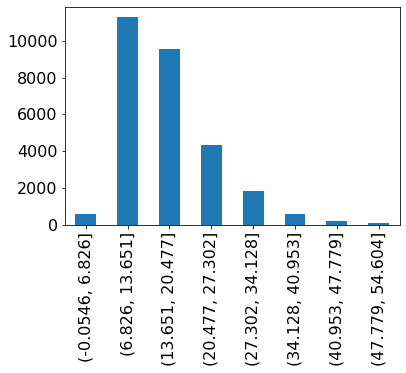

In [50]:
print('FP:  ADX')
pd.cut(df_cross['adx'], bins=8)[(df_cross['up_rsi30<25'] == 0) & (df_cross['Up?'] == 1)].value_counts().sort_index().plot(kind='bar')

TP:  ADX


<AxesSubplot:>

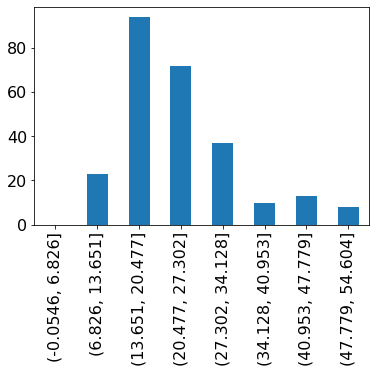

In [51]:
print('TP:  ADX')
pd.cut(df_cross['adx'], bins=8)[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 1)].value_counts().sort_index().plot(kind='bar')

FP:  +DI


<AxesSubplot:>

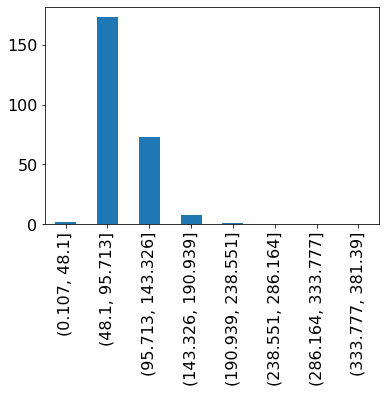

In [47]:

pd.cut(df_cross['+DI'], bins=8)[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 1)].value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

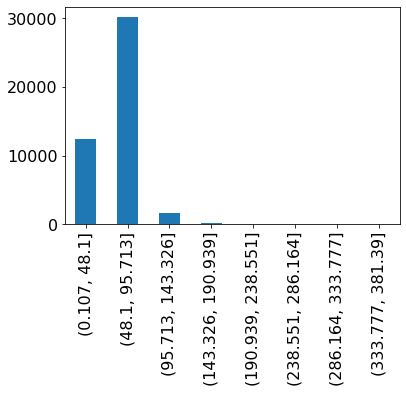

In [49]:

pd.cut(df_cross['+DI'], bins=8).value_counts().sort_index().plot(kind='bar')

TP:  ADX


<AxesSubplot:>

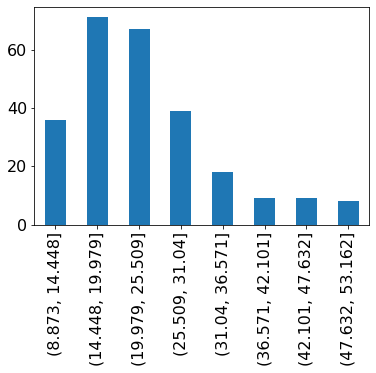

In [20]:
print('TP:  ADX')
pd.cut(df_of_tp['adx'], bins=8).value_counts().sort_index().plot(kind='bar')

TP:  +DI


<AxesSubplot:>

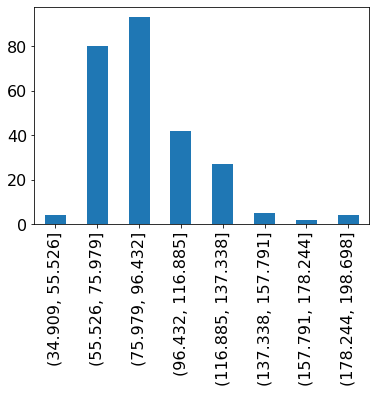

In [21]:
print('TP:  +DI')
pd.cut(df_of_tp['+DI'], bins=8).value_counts().sort_index().plot(kind='bar')

TP:  -DI


<AxesSubplot:>

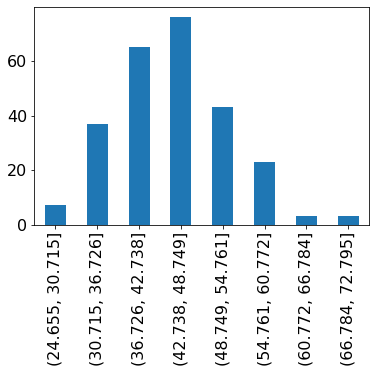

In [22]:
print('TP:  -DI')
pd.cut(df_of_tp['-DI'], bins=8).value_counts().sort_index().plot(kind='bar')

TP:  volume


<AxesSubplot:>

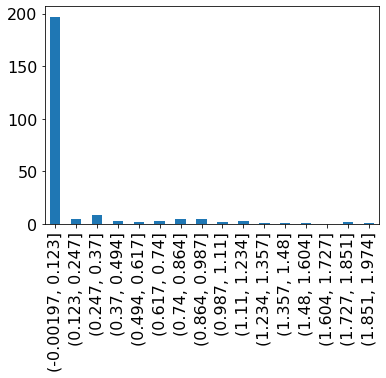

In [23]:
print('TP:  volume')
pd.cut(df_of_tp[df_of_tp['volume']<2]['volume'], bins=16).value_counts().sort_index().plot(kind='bar')

FP:  volume


<AxesSubplot:>

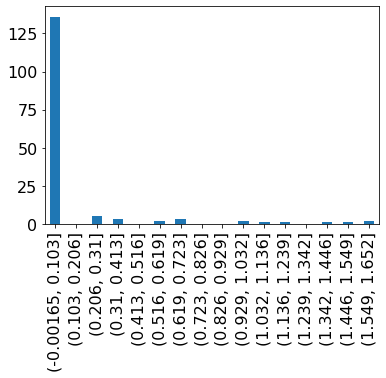

In [24]:
print('FP:  volume')
pd.cut(df_of_fp[df_of_fp['volume']<2]['volume'], bins=16).value_counts().sort_index().plot(kind='bar')

In [25]:
print('TP: +DI > -DI')
print('true:', df_of_tp[df_of_tp['-DI']<df_of_tp['+DI']]['-DI'].shape[0])
print('false:', df_of_tp[df_of_tp['-DI']>df_of_tp['+DI']]['-DI'].shape[0])

TP: +DI > -DI
true: 251
false: 6


In [26]:
print('FP: +DI > -DI')
print('true:', df_of_fp[df_of_fp['-DI']<df_of_fp['+DI']]['-DI'].shape[0])
print('false:', df_of_fp[df_of_fp['-DI']>df_of_fp['+DI']]['-DI'].shape[0])

FP: +DI > -DI
true: 163
false: 3


In [27]:
print('TP: EMA > price')
print('true:', df_of_tp[df_of_tp['price']<df_of_tp['ema10']].shape[0])
print('false:', df_of_tp[df_of_tp['ema10']>df_of_tp['price']].shape[0])

TP: EMA > price
true: 201
false: 201


In [28]:
print('FP: EMA > price')
print('true:', df_of_fp[df_of_fp['price']<df_of_fp['ema10']].shape[0])
print('false:', df_of_fp[df_of_fp['ema10']>df_of_fp['price']].shape[0])

FP: EMA > price
true: 116
false: 116


Повышения


<AxesSubplot:>

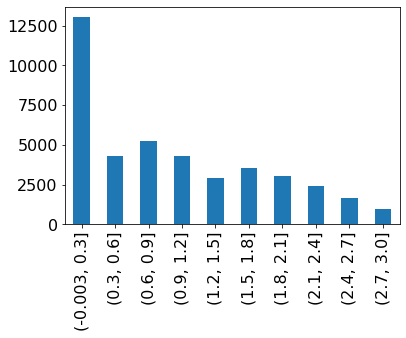

In [29]:
print('Повышения')
pd.cut(df_cross[df_cross['max_profit'] < 3]['max_profit'], bins=10).value_counts().sort_index().plot(kind='bar')

Понижения


<AxesSubplot:>

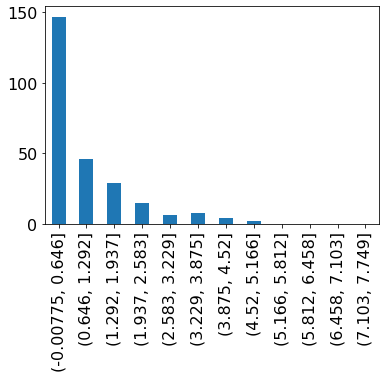

In [43]:
print('Понижения')
pd.cut(df_cross['max_loss'], bins=12)[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 1)].value_counts().sort_index().plot(kind='bar')

Понижения


<AxesSubplot:>

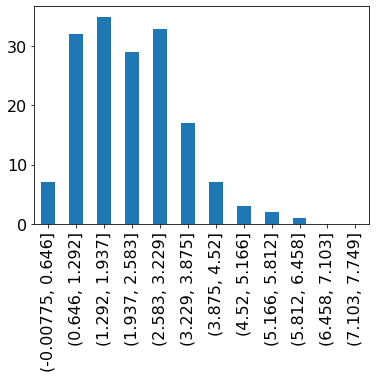

In [44]:
print('Понижения')
pd.cut(df_cross['max_loss'], bins=12)[(df_cross['up_rsi30<25'] == 1) & (df_cross['Up?'] == 0)].value_counts().sort_index().plot(kind='bar')

In [ ]:
df_cross[df_cross.index % 20 == 0]   

In [ ]:
def datetime_to_timestamp(dt):
    return time.mktime(dt.timetuple()) + dt.microsecond/1e6

print('время до профита')
pd.cut(df_cross[df_cross[df_cross.index % 20 == 0]]['time_needed'], bins=8).value_counts().sort_index().plot(kind='bar')

TP: падение 


<AxesSubplot:>

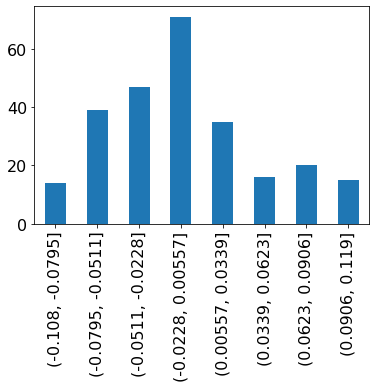

In [32]:
print('TP: падение ')
pd.cut(df_of_tp['max_fall'], bins=8).value_counts().sort_index().plot(kind='bar')

TP: падение mean


<AxesSubplot:>

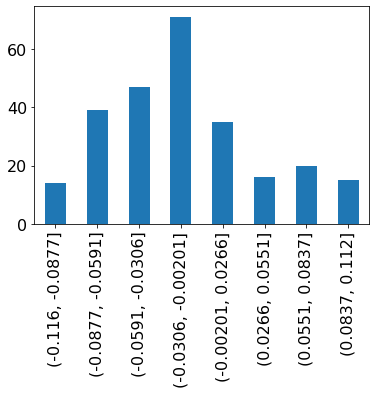

In [33]:
print('TP: падение mean')
pd.cut(df_of_tp['max_fall_mean'], bins=8).value_counts().sort_index().plot(kind='bar')

TP: падение median


<AxesSubplot:>

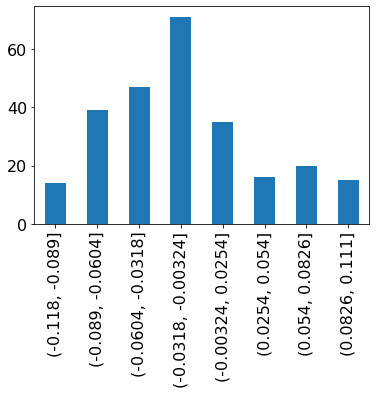

In [34]:
print('TP: падение median')
pd.cut(df_of_tp['max_fall_median'], bins=8).value_counts().sort_index().plot(kind='bar')

<AxesSubplot:>

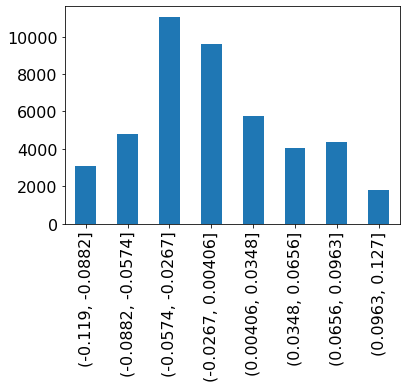

In [38]:
pd.cut(df_cross['max_fall'], bins=8).value_counts().sort_index().plot(kind='bar')

In [ ]:
pd.cut(df_cross['max_fall'], bins=8).value_counts()

FP: падение 


<AxesSubplot:>

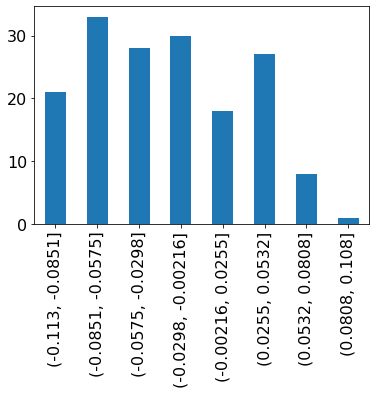

In [35]:
print('FP: падение ')
pd.cut(df_of_fp['max_fall'], bins=8).value_counts().sort_index().plot(kind='bar')

FP: падение mean


<AxesSubplot:>

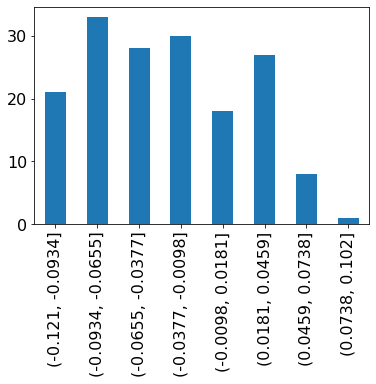

In [36]:
print('FP: падение mean')
pd.cut(df_of_fp['max_fall_mean'], bins=8).value_counts().sort_index().plot(kind='bar')

FP: падение median


<AxesSubplot:>

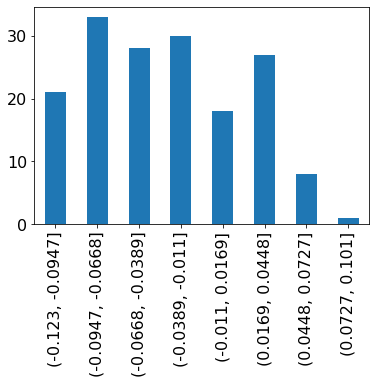

In [45]:
print('FP: падение median')
pd.cut(df_of_fp['max_fall_median'], bins=8).value_counts().sort_index().plot(kind='bar')